### Required Discussion 19:1: Building a Recommender System with SURPRISE

This discussion focuses on exploring additional algorithms with the `Suprise` library to generate recommendations.  Your goal is to identify the optimal algorithm by minimizing the mean squared error using cross validation. You are also going to select a dataset to use from [grouplens](https://grouplens.org/datasets/movielens/) example datasets.  

To begin, head over to [grouplens](https://grouplens.org/datasets/movielens/) and examine the different datasets available.  Choose one so that it is easy to create the data as expected in `Surprise` with user, item, and rating information.  Then, compare the performance of at least the `KNNBasic`, `SVD`, `NMF`, `SlopeOne`, and `CoClustering` algorithms to build your recommendations.  For more information on the algorithms see the documentation for the algorithm package [here](https://surprise.readthedocs.io/en/stable/prediction_algorithms_package.html).

Share the results of your investigation and include the results of your cross validation and a basic description of your dataset with your peers.

**Note that the solution code provided below is just an example solution. You are encouraged to manipulate choose a different dataset than the one shown below and provide questions to generate different results based on your interest.**

**For this solution file the small grouplens dataset was used: 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users**



In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 5.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357279 sha256=7320c7b309bce506e6a6ce9bf364046d66295a7a7d0074b19eca490aa89dd770
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


### Setting up data and algorithm paramters

In [ ]:
from surprise import Dataset, Reader, SVD, NMF, KNNBasic, SlopeOne, CoClustering
from surprise.model_selection import cross_validate, RandomizedSearchCV
import time
from scipy.stats import randint, uniform
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:

# Define the file path for the uploaded ratings dataset
file_path = 'data/ratings.csv'

# Load the dataset using pandas to check the structure
ratings = pd.read_csv(file_path)
print(ratings.head())

# Define the reader format for the dataset
reader = Reader(line_format='user item rating timestamp', sep=',')

# Load the dataset from the file
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [ ]:
param_dists = {
    'KNNBasic': {
        'k': randint(20, 41),
        'min_k': randint(1, 6),
        'sim_options': {
            'name': ['msd', 'cosine', 'pearson'],
            'user_based': [False, True]
        }
    },
    'SVD': {
        'n_factors': randint(50, 151),
        'n_epochs': randint(20, 31),
        'lr_all': uniform(0.005, 0.005),
        'reg_all': uniform(0.02, 0.03)
    },
    'NMF': {
        'n_factors': randint(10, 31),
        'n_epochs': randint(20, 51),
        'biased': [False, True]
    },
    'CoClustering': {
        'n_cltr_u': randint(3, 8),
        'n_cltr_i': randint(3, 8),
        'n_epochs': randint(20, 31)
    }
}

### Training pipeline

In [ ]:
algo_classes = {
    'KNNBasic': KNNBasic,
    'SVD': SVD,
    'NMF': NMF,
    'CoClustering': CoClustering
}

# Perform randomized search for each algorithm and measure training time
best_algorithms = {}
training_times = {}
testing_times = {}
for algo_name, param_dist in param_dists.items():
    print(f"Performing randomized search for {algo_name}...")
    start_time = time.time()
    rs = RandomizedSearchCV(algo_classes[algo_name], param_dist, measures=['mse'], cv=5, n_iter=20, random_state=42)
    rs.fit(data)
    end_time = time.time()
    best_algorithms[algo_name] = rs.best_estimator['mse']
    training_times[algo_name] = end_time - start_time
    testing_times[algo_name] = 0  # Initialize test time
    print(f"Best parameters for {algo_name}: {rs.best_params['mse']}")
    print(f"Training time for {algo_name}: {training_times[algo_name]:.2f} seconds")
    print("\n")

# Add SlopeOne to the best algorithms as it has no parameters to tune
best_algorithms['SlopeOne'] = SlopeOne()
training_times['SlopeOne'] = 0  # We won't measure the training time for SlopeOne as it has no parameters
testing_times['SlopeOne'] = 0  # Initialize test time for SlopeOne

# Perform cross-validation for the best algorithms found and measure training and testing times
results = {}
for algo_name, best_algo in best_algorithms.items():
    print(f"Evaluating {algo_name} with best parameters...")
    start_train_time = time.time()
    cv_results = cross_validate(best_algo, data, measures=['MSE'], cv=5, verbose=True)
    end_train_time = time.time()

    # Sum up training and testing times
    training_times[algo_name] += (end_train_time - start_train_time) - sum(cv_results['fit_time'])
    testing_times[algo_name] += sum(cv_results['test_time'])

    results[algo_name] = cv_results['test_mse']
    print(f"Total training time for {algo_name}: {training_times[algo_name]:.2f} seconds")
    print(f"Total testing time for {algo_name}: {testing_times[algo_name]:.2f} seconds")

# Find the optimal algorithm
optimal_algo = min(results, key=lambda x: results[x].mean())
optimal_mse = results[optimal_algo].mean()

print("\nOptimal Algorithm: ", optimal_algo)
print("Optimal Mean Squared Error (MSE): ", optimal_mse)
print("Training time for the optimal algorithm: {:.2f} seconds".format(training_times[optimal_algo]))
print("Testing time for the optimal algorithm: {:.2f} seconds".format(testing_times[optimal_algo]))

Performing randomized search for KNNBasic...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity m

      Algorithm  Mean MSE   Std MSE  Training Time (s)  Testing Time (s)
0      KNNBasic  0.832985  0.010442         792.432418         43.292534
1           SVD  0.742828  0.008050         201.756561          0.813290
2           NMF  0.767097  0.007167         261.743275          1.122603
3  CoClustering  0.891267  0.010233         415.757409          0.588422
4      SlopeOne  0.811546  0.010873          36.586131         35.449868


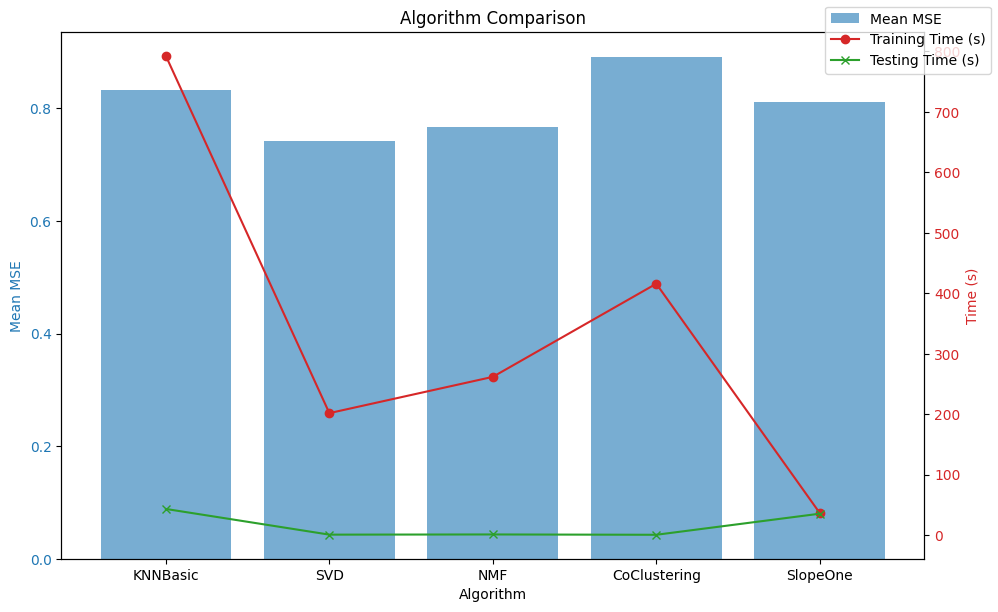

In [ ]:

# Create a DataFrame to display the results
df_results = pd.DataFrame({
    'Algorithm': list(results.keys()),
    'Mean MSE': [results[algo].mean() for algo in results],
    'Std MSE': [results[algo].std() for algo in results],
    'Training Time (s)': [training_times[algo] for algo in results],
    'Testing Time (s)': [testing_times[algo] for algo in results]
})

# Display the DataFrame
print(df_results)

# Visualization
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Algorithm')
ax1.set_ylabel('Mean MSE', color=color)
ax1.bar(df_results['Algorithm'], df_results['Mean MSE'], color=color, alpha=0.6, label='Mean MSE')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Time (s)', color=color)  # we already handled the x-label with ax1
ax2.plot(df_results['Algorithm'], df_results['Training Time (s)'], color=color, marker='o', label='Training Time (s)')
ax2.plot(df_results['Algorithm'], df_results['Testing Time (s)'], color='tab:green', marker='x', label='Testing Time (s)')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.legend(loc='upper right')
plt.title('Algorithm Comparison')
plt.show()